Generate ramp

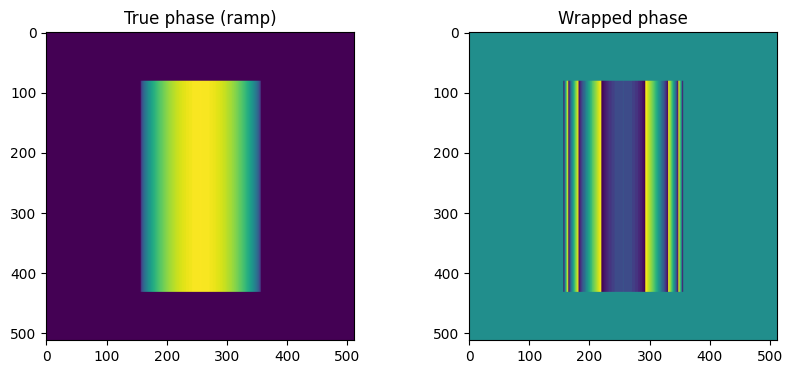

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath(".."))
from src.cylinder_phase import cylinder_phase_perp_to_z_3d

# Optics
lam   = 0.532     # wavelength (µm)
# Grid (µm/px)
Nx, Ny = 512, 512
px, py = 0.2, 0.2

# Material: either a scalar, a 2D array n(x,y), or a callable n_obj(X,Y,z)
n_obj = 1.38      # medium for cylinder
n_med = 1.33      # medium index
pz    = 0.2       # z step for integration (µm)   

# Activate for cylinder geometry

R = 20        # radius (µm)
L = 70.0          # axis length along x (µm); set None for infinite

phi_true, phi_wrapped, mask, medium_mask  = cylinder_phase_perp_to_z_3d(
    Nx, Ny, px, py,
    R, L,
    lam=lam, n_med=n_med,
    n_obj=n_obj,
    pz=pz
)

phi_wrap = phi_wrapped

"""
Ny, Nx = 200, 200
step_height = 2.5 * np.pi   # offset between the two ramps

# y axis
y = np.linspace(0, 4*np.pi, Ny//2)  # half the height ramp

# Top half ramp
top_ramp = np.tile(y[:, None], (1, Nx))

# Bottom half ramp, shifted by step_height
bottom_ramp = top_ramp + step_height

# Stack them
phi_true = np.vstack([top_ramp, bottom_ramp])

# Wrap into [-π, π]
phi_wrap = (phi_true + np.pi) % (2*np.pi) - np.pi

# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
im0 = axs[0].imshow(phi_true, cmap="viridis", origin="lower")
axs[0].set_title("True phase (two ramps)")
plt.colorbar(im0, ax=axs[0], label="Phase [rad]")

im1 = axs[1].imshow(phi_wrap, cmap="twilight", origin="lower", vmin=-np.pi, vmax=np.pi)
axs[1].set_title("Wrapped phase")
plt.colorbar(im1, ax=axs[1], label="Phase [rad]")

plt.show()

mask = np.ones_like(phi_wrap, dtype=np.float64)




"""
"""
rows, cols = 250, 250
x = np.linspace(0, 20*np.pi, cols)
phi_true = np.tile(x, (rows, 1))
phi_wrap = np.angle(np.exp(1j * phi_true))
mask = np.ones_like(phi_wrap, dtype=np.float64)
"""
# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(phi_true, cmap="viridis")
axs[0].set_title("True phase (ramp)")
axs[1].imshow(phi_wrap, cmap="viridis")
axs[1].set_title("Wrapped phase")
plt.show()



In [11]:
print("phi_wrap:", phi_wrap.shape, phi_wrap.dtype, phi_wrap.flags)
print("mask:", mask.shape, mask.dtype, mask.flags)

phi_wrap: (512, 512) float64   C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

mask: (512, 512) bool   C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



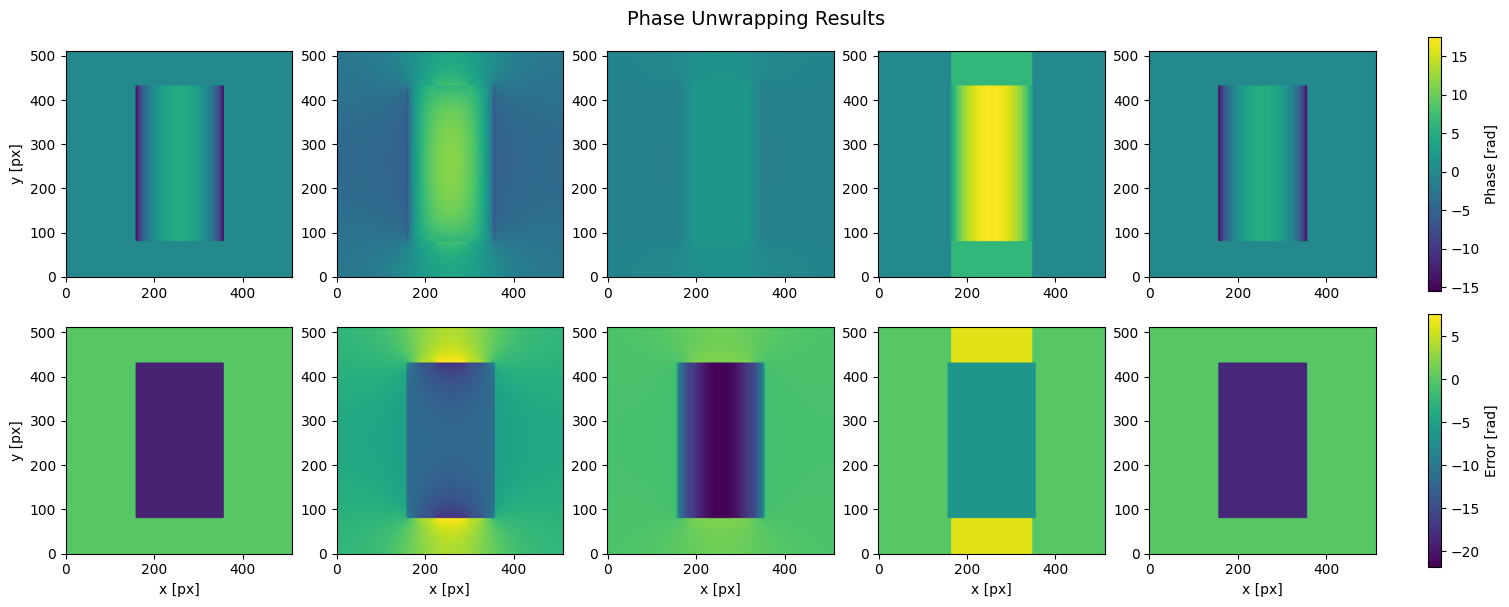

In [ ]:
from skimage.restoration import unwrap_phase
import matplotlib.pyplot as plt
import sys
from src.Ghilia.Ghilia import unwrap_phase_weighted
from src.Ghilia.reliability import reliability_weight_map
import numpy as np
import time

if not hasattr(np, "float_"):
    np.float_ = np.float64
if not hasattr(np, "int_"):
    np.int_ = np.int64
if not hasattr(np, "bool_"):
    np.bool_ = bool
from kamui import unwrap_dimensional

import math
import ctypes

dll_path = r"C:\Users\oheymans\odt-thesis\src\ARM\arm.dll"
lib = ctypes.CDLL(dll_path)

# Try to see if any "unwrap" function is in there
for name in dir(lib):
    if "unwrap" in name.lower():
        print(name)
sys.path.append(os.path.abspath("..")) 
from src.ARM.unwrap_arm import unwrap_phase_ARM
weights = reliability_weight_map(phi_wrap) * mask

# unwrap
phi_unwrapped = unwrap_phase(phi_wrap)
phi_unwrapped_LS = unwrap_phase_weighted(phi_wrap)
phi_unwrapped_kamui = unwrap_dimensional(phi_wrap)
phi_unw_ARM = unwrap_phase_ARM(
    phi_wrap, mask=mask,
    mu=1.0, lam=0.001,
    nIter=100000, ban_OmegaInit=0
)
# phi_unwrapped_puma = unwrap_dimensional(
#    phi_wrap,
#   merging_method="gc"   # "gc" = graph-cut (PUMA)
#)


# Put them in a dict for looping
results = {
    "SciPy": phi_unwrapped,
    "UnWeighted LS": phi_unwrapped_LS,
    "Kamui": phi_unwrapped_kamui,
    "ARM": phi_unw_ARM,
}

n_methods = len(results)

fig, axes = plt.subplots(2, n_methods, figsize=(3*n_methods, 6), constrained_layout=True)

# Collect all data ranges for consistent colorbars
all_unwrapped = np.concatenate([phi.flatten() for phi in results.values()])
all_errors = np.concatenate([(phi - phi_true).flatten() for phi in results.values()])

vmin_u, vmax_u = np.min(all_unwrapped), np.max(all_unwrapped)
vmin_e, vmax_e = np.min(all_errors), np.max(all_errors)

for i, phi_u in enumerate(results.values()):
    # Top: unwrapped
    im0 = axes[0, i].imshow(phi_u, cmap="viridis", origin="lower",
                            vmin=vmin_u, vmax=vmax_u)
    # Bottom: error
    err = phi_u - phi_true
    im1 = axes[1, i].imshow(err, cmap="viridis", origin="lower",
                            vmin=vmin_e, vmax=vmax_e)

    # Label only outer axes
    if i == 0:
        axes[0, i].set_ylabel("y [px]")
        axes[1, i].set_ylabel("y [px]")
    axes[1, i].set_xlabel("x [px]")

# Shared colorbars
cbar0 = fig.colorbar(im0, ax=axes[0, :], orientation="vertical", fraction=0.02, pad=0.04)
cbar0.set_label("Phase [rad]")

cbar1 = fig.colorbar(im1, ax=axes[1, :], orientation="vertical", fraction=0.02, pad=0.04)
cbar1.set_label("Error [rad]")

plt.suptitle("Phase Unwrapping Results", fontsize=14)
plt.show()